##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [7]:
#%pip install pandas 
#%pip install matplotlib
#%pip install seaborn
#%pip install numpy
#%pip install sklearn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [8]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [9]:
#Importing Libraries
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
from matplotlib.colors import LogNorm
import sklearn
from sklearn import linear_model
from pandas.api.types import is_string_dtype
from sklearn.metrics import mean_squared_error

In [10]:
#Importing the data set
data = pd.read_csv("data/catA_train.csv")

### Cleaning Data

In [11]:
#Dropping Insignificant Inputs
train = data.drop(["LATITUDE", "LONGITUDE", "8-Digit SIC Code", "8-Digit SIC Description", "Fiscal Year End","Square Footage", "AccountID",'Company Status (Active/Inactive)'],axis=1)

In [12]:
#Creating a new column indicating if the firm has overseas operation
dom = []
for i in range(len(train)):
    if train.iloc[i]["Sales (Domestic Ultimate Total USD)"] == train.iloc[i]["Sales (Global Ultimate Total USD)"]:
        dom.append(True)
    else:
        dom.append(False)
train["Pure Domestic"] = dom

In [13]:
#Cleaning domestic and global total sales (output)
newcol = []
for i in range(len(train)):
    if train.iloc[i]["Pure Domestic"]:
        newcol.append(train.iloc[i]["Sales (Global Ultimate Total USD)"])
    else:
        domsale = train.iloc[i]["Sales (Domestic Ultimate Total USD)"]
        glosale = train.iloc[i]["Sales (Global Ultimate Total USD)"]
        if domsale < glosale:
            newcol.append(glosale)
        elif domsale > glosale:
            # To stay consistent, global ultimate total sale is treated as including domestic ultimate total sale.
            newcol.append(glosale + domsale)
        else:
            #try catching any exception. There are none.
            raise Exception
train["Sales (Global Ultimate Total USD)"] = newcol

In [14]:
#Cleaning domestic and global employee number
train["Employees (Single Site)"].fillna(0, inplace=True)
train['Employees (Global Ultimate Total)'].fillna(0, inplace=True)
train['Employees (Domestic Ultimate Total)'].fillna(0, inplace=True)
companies = {} #key: company name, value: index
for i in range(len(train)):
    curr_coy = train.iloc[i]["Company"] #current company
    if curr_coy not in companies:
        companies[curr_coy] = []
    companies[curr_coy].append(i)

for value in companies.values():
    total_domestic_employee = 0
    for i in value:
        total_domestic_employee += train.iloc[i]["Employees (Single Site)"]
    if train.iloc[i]["Employees (Domestic Ultimate Total)"] >= total_domestic_employee:
        continue
    else:
        train.loc[value, "Employees (Domestic Ultimate Total)"] = total_domestic_employee

newcol=[]
for i in range(len(train)): #global ultimate total should include domestic ultimate total
    domemp = train.iloc[i]["Employees (Domestic Ultimate Total)"]
    gloemp = train.iloc[i]["Employees (Global Ultimate Total)"]
    if not gloemp or domemp >= gloemp:
        newcol.append(domemp)
    else:
        newcol.append(gloemp)
train["Employees (Global Ultimate Total)"] = newcol

# Exploratory Data Analytics

In [15]:
#Overview of data frame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Company                              29182 non-null  object 
 1   SIC Code                             29182 non-null  int64  
 2   Industry                             29182 non-null  object 
 3   Year Found                           28748 non-null  float64
 4   Entity Type                          29182 non-null  object 
 5   Parent Company                       28668 non-null  object 
 6   Parent Country                       28662 non-null  object 
 7   Ownership Type                       29182 non-null  object 
 8   Company Description                  29182 non-null  object 
 9   Employees (Single Site)              29182 non-null  float64
 10  Employees (Domestic Ultimate Total)  29182 non-null  float64
 11  Employees (Global Ultimate T

In [16]:
#Converting categorical columns into categorical variables
cat_col = ["SIC Code", "Industry", "Entity Type", "Ownership Type", "Import/Export Status", "Is Domestic Ultimate", "Is Global Ultimate"]
for i in cat_col:
    train[i] = train[i].astype("category")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Company                              29182 non-null  object  
 1   SIC Code                             29182 non-null  category
 2   Industry                             29182 non-null  category
 3   Year Found                           28748 non-null  float64 
 4   Entity Type                          29182 non-null  category
 5   Parent Company                       28668 non-null  object  
 6   Parent Country                       28662 non-null  object  
 7   Ownership Type                       29182 non-null  category
 8   Company Description                  29182 non-null  object  
 9   Employees (Single Site)              29182 non-null  float64 
 10  Employees (Domestic Ultimate Total)  29182 non-null  float64 
 11  Employees (Glob

In [17]:
#Analysis Data, Drop Insignificant Inputs
analysis = train.drop(["Company", "Parent Company", "Parent Country", "Company Description", "Global Ultimate Company", "Global Ultimate Country", "Domestic Ultimate Company"], axis=1)

In [18]:
#Cleaning up industry
industry_dct = {}

for k, v in companies.items():
    curr_industry = analysis.iloc[v[0]]["SIC Code"]
    if curr_industry not in industry_dct:
        industry_dct[curr_industry] = 0
    industry_dct[curr_industry] += 1
industries = pd.DataFrame(sorted(tuple(industry_dct.items()), key = lambda x: x[1], reverse =True))

print(industries.describe())

#Classifying all industries with 7 firms and below as "others"
min_firms = 8
industries_low_num = []
for k, v in industry_dct.items():
    if v < min_firms:
        if k not in industries_low_num:
            industries_low_num.append(k)

newcol = []
for i in range(len(analysis)):
    curr_industry = analysis.iloc[i]["SIC Code"]
    if curr_industry in industries_low_num:
        newcol.append("Others")
    else:
        newcol.append(curr_industry)

analysis["SIC Code"] = newcol

                 0            1
count   582.000000   582.000000
mean   4742.891753    50.140893
std    2143.672379   337.037561
min     132.000000     2.000000
25%    3299.250000     4.000000
50%    4724.500000     8.000000
75%    6157.500000    24.000000
max    9721.000000  7753.000000


In [19]:
#Summary of industries
analysis["SIC Code"].describe()

count     29182
unique      307
top        6719
freq       7753
Name: SIC Code, dtype: int64

In [20]:
#Frequency of different industries
print (industries)

        0     1
0    6719  7753
1    8742  1389
2    7371   778
3    4731   737
4    7389   694
..    ...   ...
577  7291     2
578  3085     2
579  4311     2
580  3965     2
581  3845     2

[582 rows x 2 columns]


Correlation Analysis

In [21]:
correlation = analysis.drop(["Industry"],axis=1)
correlation.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,SIC Code,Year Found,Entity Type,Ownership Type,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Is Domestic Ultimate,Is Global Ultimate,Pure Domestic
SIC Code,1.000000,0.044398,-0.117973,0.018854,0.236117,0.184035,0.106042,0.212300,0.174716,0.224413,-0.007553,-0.100300,-0.091704
Year Found,0.044398,1.000000,0.016697,0.048914,0.013315,0.020574,0.008706,0.029391,0.010680,0.121585,0.028670,0.034152,0.008930
Entity Type,-0.117973,0.016697,1.000000,0.065126,-0.249080,-0.098008,-0.186333,-0.124752,-0.127663,-0.102564,0.410506,0.812900,0.360633
Ownership Type,0.018854,0.048914,0.065126,1.000000,-0.010184,0.042920,-0.014648,-0.000990,-0.008698,0.010338,0.032188,0.085852,0.059443
Employees (Single Site),0.236117,0.013315,-0.249080,-0.010184,1.000000,0.368924,0.168522,0.108407,0.088050,0.108468,-0.142657,-0.271206,-0.132104
Employees (Domestic Ultimate Total),0.184035,0.020574,-0.098008,0.042920,0.368924,1.000000,0.383653,0.220805,0.185970,0.140990,-0.024460,-0.108756,-0.155894
Employees (Global Ultimate Total),0.106042,0.008706,-0.186333,-0.014648,0.168522,0.383653,1.000000,0.370526,0.435142,0.164183,0.192660,-0.184305,-0.455619
Sales (Domestic Ultimate Total USD),0.212300,0.029391,-0.124752,-0.000990,0.108407,0.220805,0.370526,1.000000,0.837077,0.303467,0.298146,-0.111758,-0.443108
Sales (Global Ultimate Total USD),0.174716,0.010680,-0.127663,-0.008698,0.088050,0.185970,0.435142,0.837077,1.000000,0.234821,0.333932,-0.110487,-0.494128
Import/Export Status,0.224413,0.121585,-0.102564,0.010338,0.108468,0.140990,0.164183,0.303467,0.234821,1.000000,0.109135,-0.084422,-0.211732


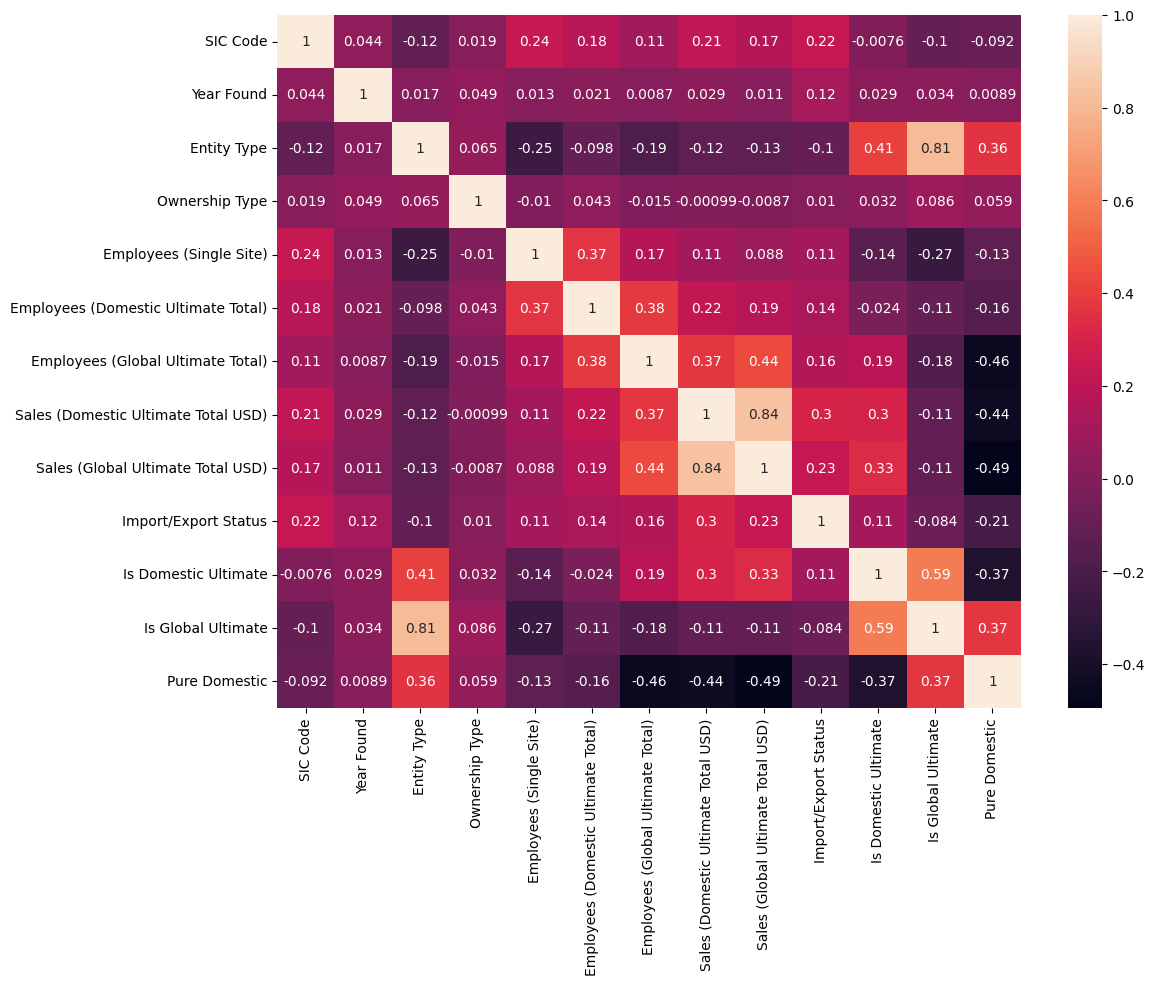

In [22]:
#Correlation Heatmap
fig, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(correlation.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1),annot=True)
plt.show()

From this heat map, it is very clear that there are very weak or no correlation ( |r| < 0.15 ) between domestic ultimate total sales and year found, entity type, ownership type, single site employees, whether the company is global ultimate or not. We can see that there are moderate correlation (0.15 < |r| < 0.5)between domestic ultimate total sales and the SIC Code, industry, domestic ultimate total employee, global ultimate total employee, import/export status, whether the company is domestic ultimate and whether the company is purely domestic. There are strong correlation (|r| > 0.5) between domestic ultimate total sales and global ultimate total sales.

# Data Exploration

### Analysing Relationship between industries and total domestic sales

In [23]:
print(analysis[['SIC Code',"Sales (Domestic Ultimate Total USD)"]].describe())

       Sales (Domestic Ultimate Total USD)
count                         2.918200e+04
mean                          7.520992e+08
std                           1.019636e+10
min                          -1.502631e+08
25%                           1.026308e+06
50%                           2.606644e+06
75%                           2.176969e+07
max                           3.184760e+11


In [24]:
#Finding Mean of Domestic Sales for differnet industries
res ={}
for k, v in companies.items():
    curr_industry = analysis.iloc[v[0]]["SIC Code"]
    if curr_industry not in res:
        res[curr_industry] = [0,0]
    res[curr_industry][0] += analysis.iloc[v[0]]["Sales (Domestic Ultimate Total USD)"]
    res[curr_industry][1] += 1
for i in res:
    res[i] = res[i][0] / res[i][1]
industries_sales = pd.DataFrame(sorted(tuple(res.items()), key = lambda x: x[1], reverse =True))
print(industries_sales)


In [ ]:
#Finding Outlier Industry
for j in range(len(analysis)):
    if analysis.iloc[j]['SIC Code'] == 2911:
        print(analysis['Industry'][j])
        break

Petroleum Refining


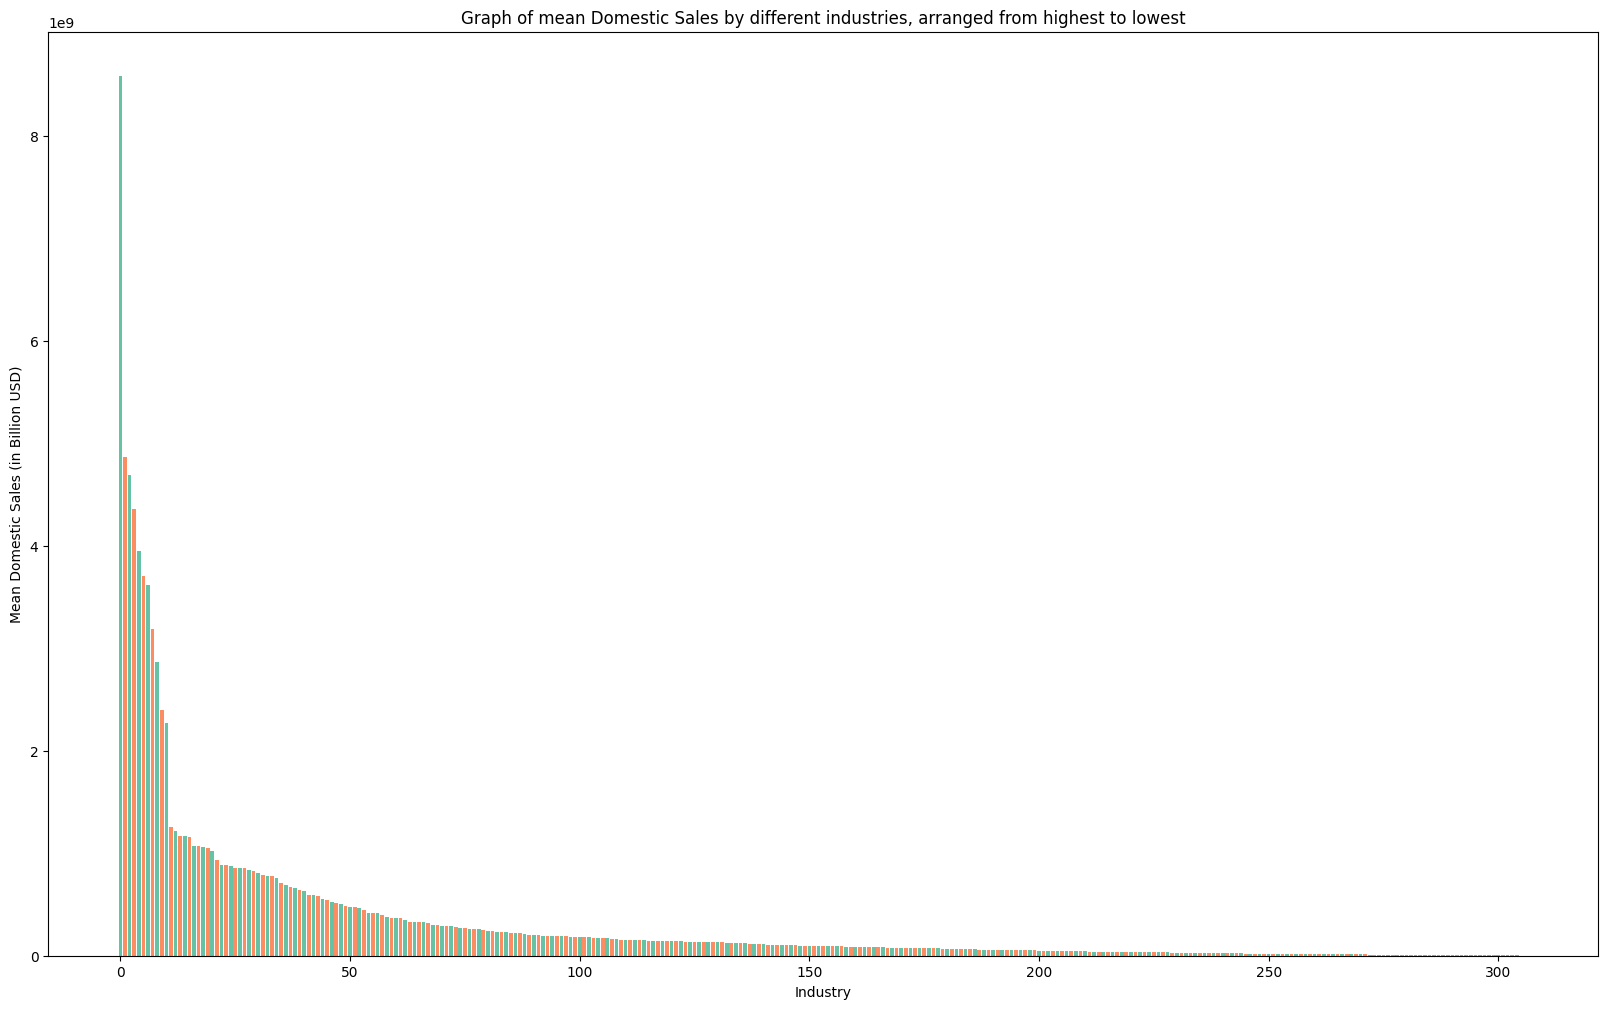

In [ ]:
#Graph Showing Relationship Between Industry and Sales
y = industries_sales[1]
x = [x for x in range(len(y))]
fig, ax = plt.subplots(figsize=(20, 12))

colours = sb.color_palette("Set2", n_colors = 2)
plt.bar(x,y,color = colours)

#plt.plot(x,y)
plt.xlabel('Industry') and plt.ylabel('Mean Domestic Sales (in Billion USD)')
plt.title('Graph of mean Domestic Sales by different industries, arranged from highest to lowest')
plt.show()

As can be seen, the highest peak indicating the greatest mean domestic sales corresponds to the petroleum refining industry, indicating that companies within that industry have the highest domestic sales.

### Analysing Domestic Sales and employees for firms with and without overseas operation

Data cleaning for Domestic Total Sales

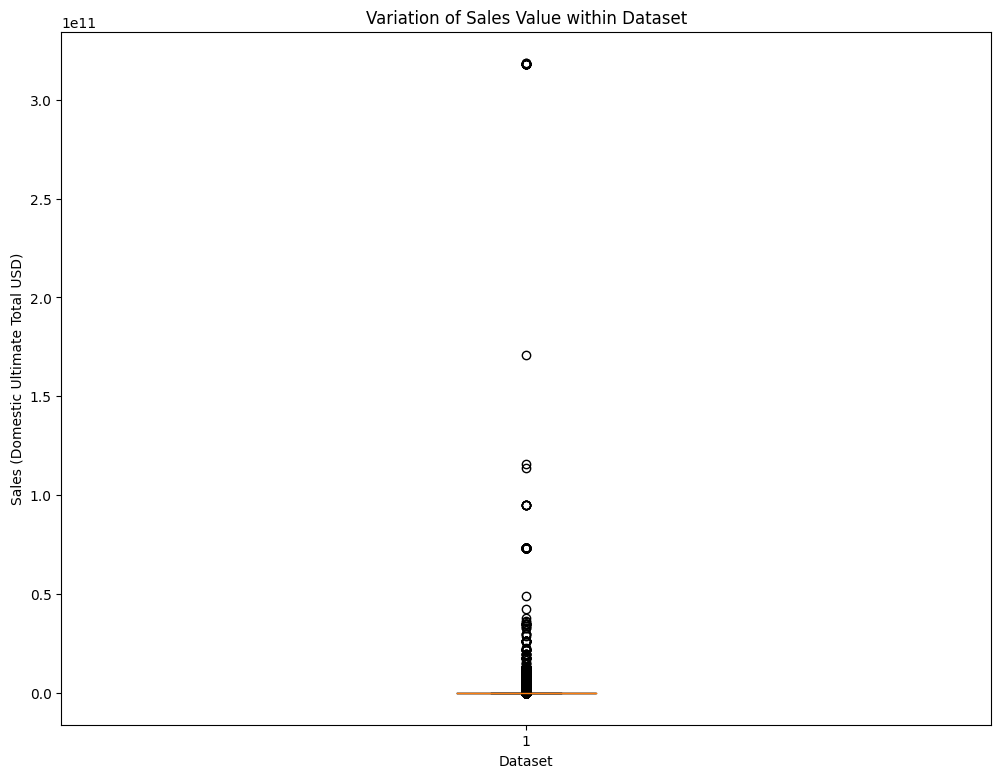

In [ ]:
boxplot = plt.figure(figsize = (12,9))
plt.boxplot(analysis["Sales (Domestic Ultimate Total USD)"])
plt.xlabel('Dataset') and plt.ylabel('Sales (Domestic Ultimate Total USD)')
plt.title('Variation of Sales Value within Dataset')
plt.show()

As seen, there are many outliers affecting the distribution of sales.

In [ ]:
#Identifying outliers
Q1 = analysis['Sales (Domestic Ultimate Total USD)'].quantile(0.25)
Q3 = analysis['Sales (Domestic Ultimate Total USD)'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
outliers = analysis[(analysis['Sales (Domestic Ultimate Total USD)'] < Q1 - threshold * IQR) | (analysis['Sales (Domestic Ultimate Total USD)'] > Q3 + threshold * IQR)]

#Dropping the outliers
analysis= analysis.drop(outliers.index)

analysis.describe()

,Year Found,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD)
count,23392.000000,23722.000000,23722.000000,2.372200e+04,2.372200e+04,2.372200e+04
mean,2005.577420,17.609561,50.230841,4.944863e+03,6.174991e+06,2.517549e+09
std,12.863852,91.660499,398.860668,3.602824e+04,9.887269e+06,1.607215e+10
min,1887.000000,0.000000,0.000000,0.000000e+00,-4.535330e+05,1.370000e+02
25%,1999.000000,0.000000,8.000000,1.000000e+01,1.026308e+06,1.026308e+06
50%,2008.000000,8.000000,15.000000,2.000000e+01,1.320990e+06,2.406738e+06
75%,2015.000000,20.000000,40.000000,8.000000e+01,7.269371e+06,2.109360e+07
max,2023.000000,6500.000000,40000.000000,2.190000e+06,5.282967e+07,5.140000e+11


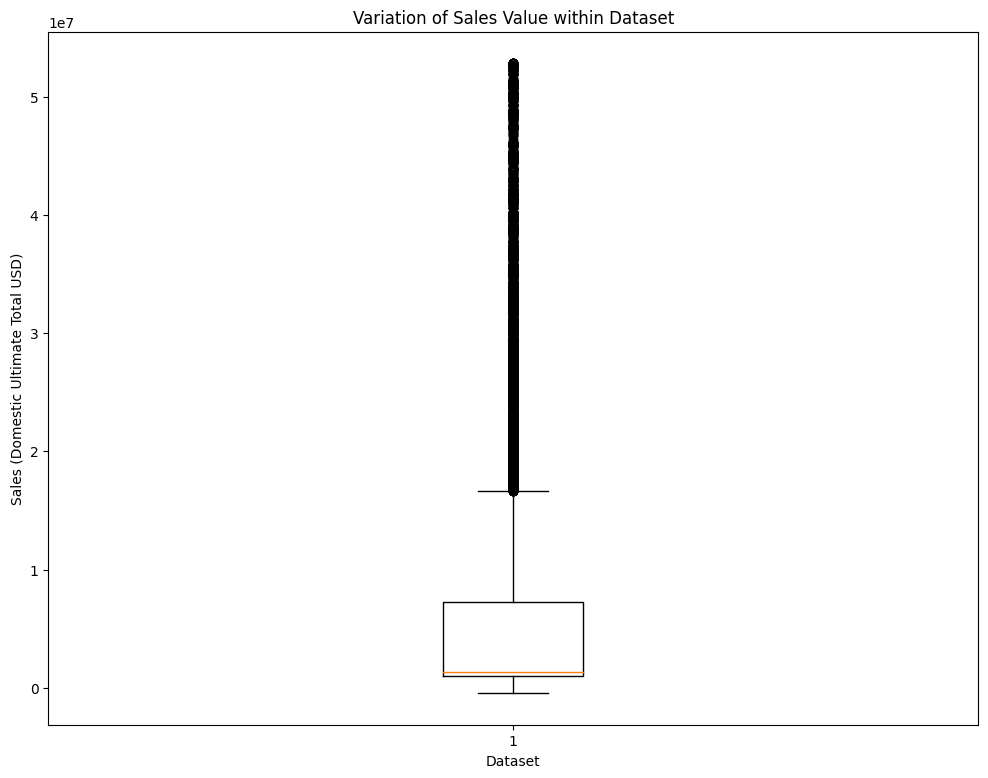

In [ ]:
#Updated Boxplot from Removal of Outliers
boxplot = plt.figure(figsize = (12,9))
plt.boxplot(analysis["Sales (Domestic Ultimate Total USD)"])
plt.xlabel('Dataset') and plt.ylabel('Sales (Domestic Ultimate Total USD)')
plt.title('Variation of Sales Value within Dataset')
plt.show()

Data cleaning for Domestic Total Employee

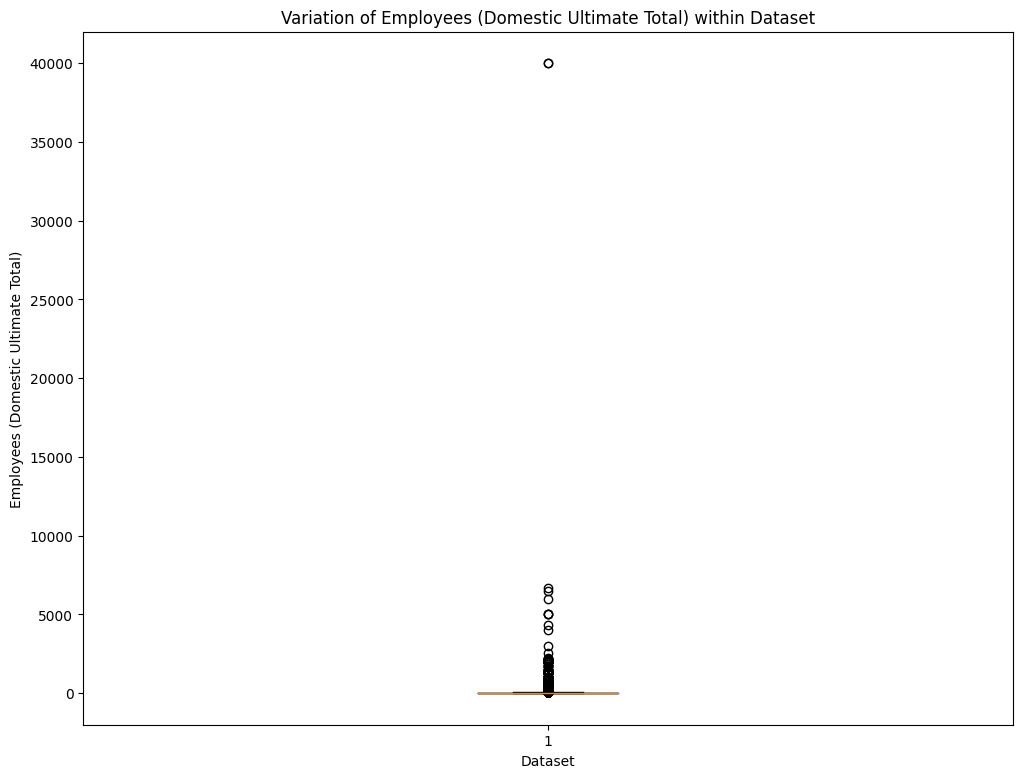

In [ ]:
boxplot = plt.figure(figsize = (12,9))
plt.boxplot(analysis["Employees (Domestic Ultimate Total)"])
plt.xlabel('Dataset') and plt.ylabel('Employees (Domestic Ultimate Total)')
plt.title('Variation of Employees (Domestic Ultimate Total) within Dataset')
plt.show()

As seen, there are many outliers for total domestic employee number too.

In [ ]:
#Identifying outliers
Q1 = analysis['Employees (Domestic Ultimate Total)'].quantile(0.25)
Q3 = analysis['Employees (Domestic Ultimate Total)'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
outliers = analysis[(analysis['Employees (Domestic Ultimate Total)'] < Q1 - threshold * IQR) | (analysis['Employees (Domestic Ultimate Total)'] > Q3 + threshold * IQR)]

#Dropping the outliers
analysis= analysis.drop(outliers.index)

analysis.describe()

,Year Found,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD)
count,20833.000000,21134.000000,21134.000000,2.113400e+04,2.113400e+04,2.113400e+04
mean,2006.173379,10.585549,20.900729,4.980941e+03,4.869409e+06,2.560557e+09
std,12.629935,14.148720,19.882863,3.732072e+04,8.266339e+06,1.652764e+10
min,1906.000000,0.000000,0.000000,0.000000e+00,-4.535330e+05,1.370000e+02
25%,2000.000000,0.000000,5.000000,7.000000e+00,1.026308e+06,1.026308e+06
50%,2009.000000,7.000000,13.000000,1.500000e+01,1.026308e+06,1.630838e+06
75%,2016.000000,15.000000,29.000000,4.800000e+01,4.489921e+06,1.697339e+07
max,2023.000000,88.000000,88.000000,2.190000e+06,5.258954e+07,5.140000e+11


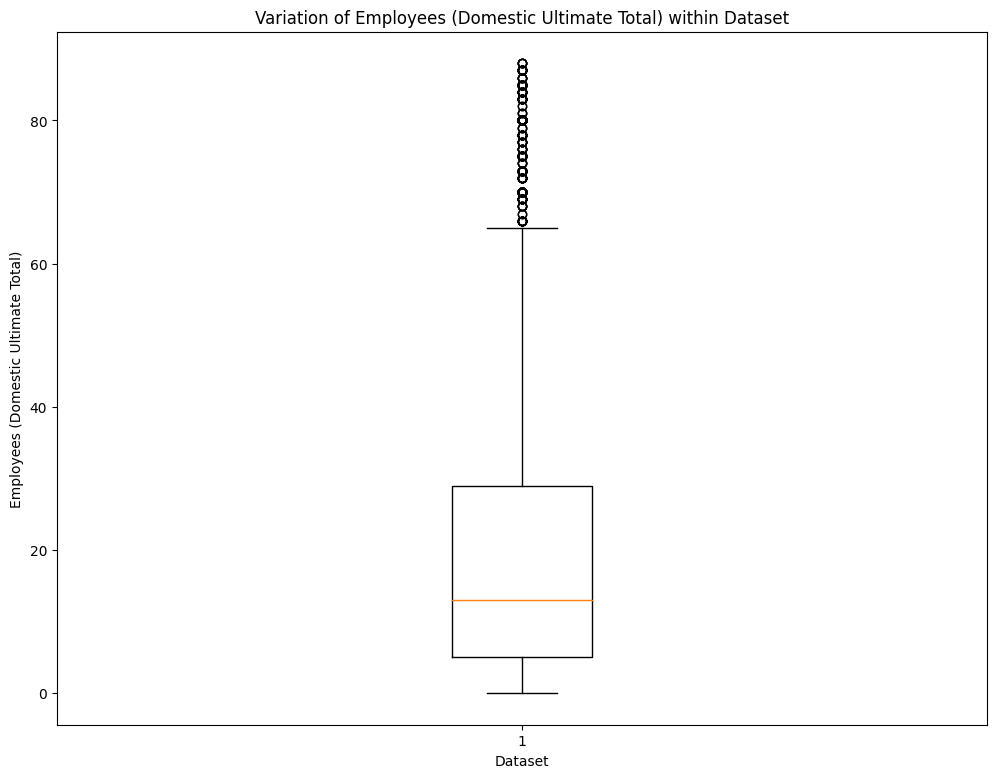

In [ ]:
#Updated Boxplot from Removal of Outliers
boxplot = plt.figure(figsize = (12,9))
plt.boxplot(analysis["Employees (Domestic Ultimate Total)"])
plt.xlabel('Dataset') and plt.ylabel('Employees (Domestic Ultimate Total)')
plt.title('Variation of Employees (Domestic Ultimate Total) within Dataset')
plt.show()

In [ ]:
#print(analysis[['Employees (Domestic Ultimate Total)',"Sales (Domestic Ultimate Total USD)"]].describe())

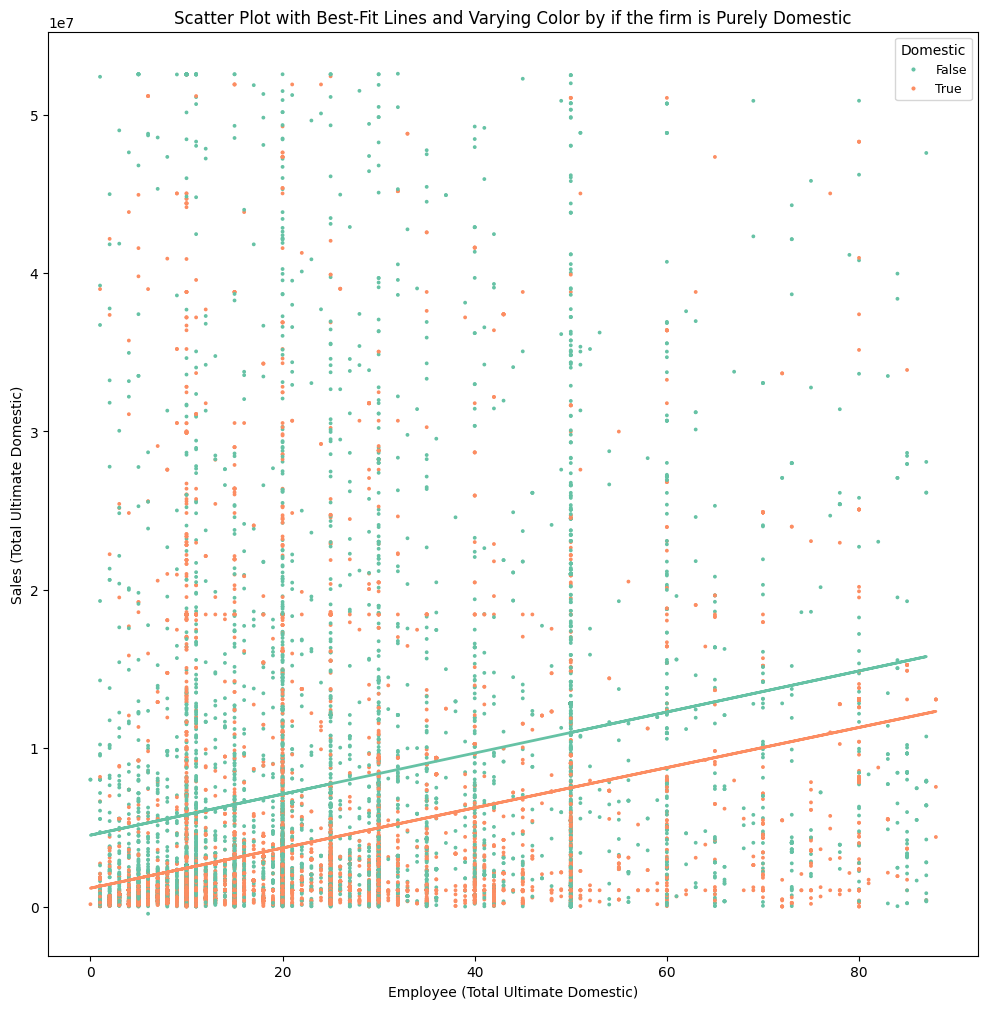

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
norm = LogNorm()

domestic = analysis["Pure Domestic"].unique()
colours = sb.color_palette("Set2", n_colors=len(domestic))
colours_dict = dict([(domestic[i], colours[i]) for i in range(len(domestic))])

# Scatter plot
scatter_1 = plt.scatter(
    analysis['Employees (Domestic Ultimate Total)'],
    analysis["Sales (Domestic Ultimate Total USD)"],
    c=tuple(map(lambda x: colours_dict[x], analysis["Pure Domestic"])),
    s=3
)

# Plotting the best fit lines
for category in domestic:
    subset = analysis[analysis["Pure Domestic"] == category]
    x = subset['Employees (Domestic Ultimate Total)']
    y = subset["Sales (Domestic Ultimate Total USD)"]
    a,b= np.polyfit(x, y, 1)
    plt.plot(x, a*x+b, color=colours_dict[category], linewidth=2)

# Legend

label = analysis['Pure Domestic'].unique()
handle = [plt.Line2D([0], [0], marker='o', color='w', label=i, markerfacecolor=colours_dict[i], markersize=4) for i in label]
plt.legend(handles=handle, title='Domestic', prop={'size': 9}, loc='upper right', bbox_to_anchor=(1, 1))

# Axes labels and title
plt.xlabel('Employee (Total Ultimate Domestic)')
plt.ylabel('Sales (Total Ultimate Domestic)')
plt.title('Scatter Plot with Best-Fit Lines and Varying Color by if the firm is Purely Domestic')

# Show the plot
plt.show()

As seen in this graph, the firms that are not domestic only would generally have a higher profit than those who are domestic only.

# Predictive Modelling 

## Model 1 (65.7% of dataset predicted)

In [ ]:
#Comparing Employee Numbers (Domestic and Global)
glodom = data[data['Employees (Domestic Ultimate Total)']<data['Employees (Global Ultimate Total)']]
domglo = data[data['Employees (Domestic Ultimate Total)']>data['Employees (Global Ultimate Total)']]
EMPeqs = data[data['Employees (Domestic Ultimate Total)']==data['Employees (Global Ultimate Total)']]

In [ ]:
dEmp = 'Employees (Domestic Ultimate Total)'
gEmp = 'Employees (Global Ultimate Total)'
dSale = 'Sales (Domestic Ultimate Total USD)'
gSale = 'Sales (Global Ultimate Total USD)'

In [ ]:
cols = ['Ownership Type', 'Entity Type','Is Global Ultimate', 'Is Domestic Ultimate', 'Pure Domestic']

In [ ]:
test = EMPeqs[EMPeqs['Global Ultimate Country']=='Singapore']
act = test[dSale]
pred = []
wrong = []

for i in range(len(test)):
    pred.append(test.iloc[i][gSale])
    if pred[i] != act.iloc[i]:
        wrong.append(i)

import sklearn
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(act, pred)
print(mse)

0.0


This model relies on the figures of global ultimate total sales to be available in order to predict domestic ultimate total sale. This may be severely limited in its scope in real life application when making predictive data analytics. However, it does carries a high accurary and highlights that any Singapore bases firm without overseas operation would not have any revenue from overseas.

# Model 2

In [ ]:
todrop=[]
for colname in train.columns:  
    if is_string_dtype(train[colname]):
        todrop.append(colname)
todrop.extend(["Global Ultimate Company", "Parent Company","8-Digit SIC Description", "Industry","SIC code","Domestic Ultimate Company","Parent Country","Import/Export Status","Global Ultimate Country"\
               ,"Fiscal Year End","SIC Code","8-Digit SIC Code", "Is Domestic Ultimate", "Is Global Ultimate", "Pure Domestic"])

In [ ]:
print(todrop)
for colname in todrop:
    try:
        train=train.drop(columns=colname)
    except:
        continue

['Company', 'Industry', 'Entity Type', 'Ownership Type', 'Company Description', 'Import/Export Status', 'Global Ultimate Company', 'Parent Company', '8-Digit SIC Description', 'Industry', 'SIC code', 'Domestic Ultimate Company', 'Parent Country', 'Import/Export Status', 'Global Ultimate Country', 'Fiscal Year End', 'SIC Code', '8-Digit SIC Code', 'Is Domestic Ultimate', 'Is Global Ultimate', 'Pure Domestic']


#### Setting seed for train/test split, 10% of data reserved for test set along with declaration of variables

In [ ]:
train.fillna(value=0)
mtrain=train.sample(frac=0.9,random_state=128642)
mtest=train.drop(mtrain.index)

In [ ]:
print(train.columns)

Index(['Year Found', 'Employees (Single Site)',
       'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)'],
      dtype='object')


#### Declaration of predictors

In [ ]:
vars=[]
for var in train.columns:
    vars.append(var)
outputs=['Sales (Domestic Ultimate Total USD)']
for var in outputs:
    if var in vars:
        vars.remove(var)

print(vars, outputs)

['Year Found', 'Employees (Single Site)', 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)', 'Sales (Global Ultimate Total USD)'] ['Sales (Domestic Ultimate Total USD)']


In [ ]:
x=mtrain[vars]
y=mtrain[outputs[0]]
xtest=mtest[vars]
ytest=mtest[outputs[0]]
xtest = xtest.fillna(xtest.mean())

#### Linear Regression

In [ ]:
x=mtrain[vars]
y=mtrain[outputs[0]]
x = x.fillna(x.mean())
lm1=linear_model.LinearRegression()
lm1.fit(x,y)

LinearRegression()

In [ ]:
y_pred = lm1.predict(xtest)
mse = mean_squared_error(ytest, y_pred)
print((mse**0.5)//1000000)

11413.0


#### Gradient boosted

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Assuming x_train, y_train are the training set independent and dependent variables
# Assuming x_test, y_test are the test set independent and dependent variables

# Create a Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(n_estimators=1000)

# Fit the model to the training set
gbr.fit(x, y)

# Predict on the test set
y_pred = gbr.predict(xtest)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(ytest, y_pred)

# Print the MSE
print((mse**0.5)//1000000)


1921.0


#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming x_train, y_train are the training set independent and dependent variables
# Assuming x_test, y_test are the test set independent and dependent variables

# Create a Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100)

# Fit the model to the training set
rf.fit(x, y)

# Predict on the test set
y_pred = rf.predict(xtest)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(ytest, y_pred)
# Print the MSE
print((mse**0.5)/1000000)

2136.2944451694416


As shown by the result, gradient boosting regressor has the least MSE values. Hence, this method is chosen.

# train model*()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def train_model():
    """
    Train a Gradient Boosting Regressor model.

    Parameters:
    - x_train: Independent variables of the training set
    - y_train: Dependent variable of the training set

    Returns:
    - gbr: Trained Gradient Boosting Regressor model
    """
    # Create a Gradient Boosting Regressor model
    gbr2 = GradientBoostingRegressor(n_estimators=1000)

    # Fit the model to the training set
    gbr2.fit(x, y)

    # Return the trained model
    global gbr
    gbr=gbr2
train_model()

SyntaxError: invalid syntax (566554266.py, line 21)

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    ## Data Cleaning
    #Dropping Insignificant Inputs
    test = hidden_data.drop(["LATITUDE", "LONGITUDE", "8-Digit SIC Code", "8-Digit SIC Description", "Fiscal Year End","Square Footage", "AccountID",'Company Status (Active/Inactive)'],axis=1)
    
    #Cleaning domestic and global employee number
    test["Employees (Single Site)"].fillna(0, inplace=True)
    test['Employees (Global Ultimate Total)'].fillna(0, inplace=True)
    test['Employees (Domestic Ultimate Total)'].fillna(0, inplace=True)
    companies = {} #key: company name, value: index
    for i in range(len(test)):
        curr_coy = test.iloc[i]["Company"] #current company
        if curr_coy not in companies:
            companies[curr_coy] = []
        companies[curr_coy].append(i)

    for value in companies.values():
        total_domestic_employee = 0
        for i in value:
            total_domestic_employee += test.iloc[i]["Employees (Single Site)"]
        if test.iloc[i]["Employees (Domestic Ultimate Total)"] >= total_domestic_employee:
            continue
        else:
            test.loc[value, "Employees (Domestic Ultimate Total)"] = total_domestic_employee

    newcol=[]
    for i in range(len(test)): #global ultimate total should include domestic ultimate total
        domemp = test.iloc[i]["Employees (Domestic Ultimate Total)"]
        gloemp = test.iloc[i]["Employees (Global Ultimate Total)"]
        if not gloemp or domemp >= gloemp:
            newcol.append(domemp)
        else:
            newcol.append(gloemp)
    test["Employees (Global Ultimate Total)"] = newcol

    todrop=[]
    for colname in test.columns:  
        if is_string_dtype(test[colname]):
            todrop.append(colname)
    todrop.extend(["Global Ultimate Company", "Parent Company","8-Digit SIC Description", "Industry","SIC code","Domestic Ultimate Company","Parent Country","Import/Export Status","Global Ultimate Country"\
                ,"Fiscal Year End","SIC Code","8-Digit SIC Code", "Is Domestic Ultimate", "Is Global Ultimate"])
    
    for colname in todrop:
        try:
            test=test.drop(columns=colname)
        except:
            continue

    #Declaration of predictors
    vars=[]
    for var in test.columns:
        vars.append(var)
    outputs=['Sales (Domestic Ultimate Total USD)']
    for var in outputs:
        if var in vars:
            vars.remove(var)

    xtest=test[vars]
    xtest = xtest.fillna(xtest.mean())

    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import mean_squared_error

    # Predict on the test set
    y_pred = gbr.predict(xtest)


    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = y_pred 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[-5.66152870e+06  6.36248371e+09  1.09886218e+05 ...  1.69549049e+08
  3.37407322e+06 -1.14476016e+06]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!